## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

### 1.1 IVT Data

In [3]:
variable_ivt = '__xarray_dataarray_variable__'

#### 1.1.1 ERA5

In [4]:
# era5
ivt_era5_urban = xr.open_dataset(r'data/ivt_era5_postprocessed_urban.nc')
ivt_era5_nourban = xr.open_dataset(r'data/ivt_era5_postprocessed_nourban.nc')

#### 1.1.2 GFS

In [5]:
# gfs
ivt_gfs_urban = xr.open_dataset(r'data/ivt_gfs_postprocessed_urban.nc')
ivt_gfs_nourban = xr.open_dataset(r'data/ivt_gfs_postprocessed_nourban.nc')

### 1.2 PRCP Data

In [6]:
variable_prcp = 'PRCP'

#### 1.2.1 ERA5

In [7]:
# era5
prcp_era5_urban_clip = xr.open_dataset(r'data/prcp_era5_postprocessed_urban.nc')
prcp_era5_nourban_clip = xr.open_dataset(r'data/prcp_era5_postprocessed_nourban.nc')

#### 1.2.2 GFS

In [8]:
# gfs
prcp_gfs_urban_clip = xr.open_dataset(r'data/prcp_gfs_postprocessed_urban.nc')
prcp_gfs_nourban_clip = xr.open_dataset(r'data/prcp_gfs_postprocessed_nourban.nc')

## 2. Vectorize Tiff Data

In [9]:
proj_dt = xr.open_dataset(r'data/era5_LIN_nourban_ACLHF_wrfout_d03_2017-07-17.nc')
proj_dt = proj_dt.rio.write_crs(proj_dt['ACLHF'].attrs['pyproj_srs'])

In [10]:
gg = rioxarray.open_rasterio('data/lu_index/urban_luse_border_raster.tiff').squeeze('band', drop=True)

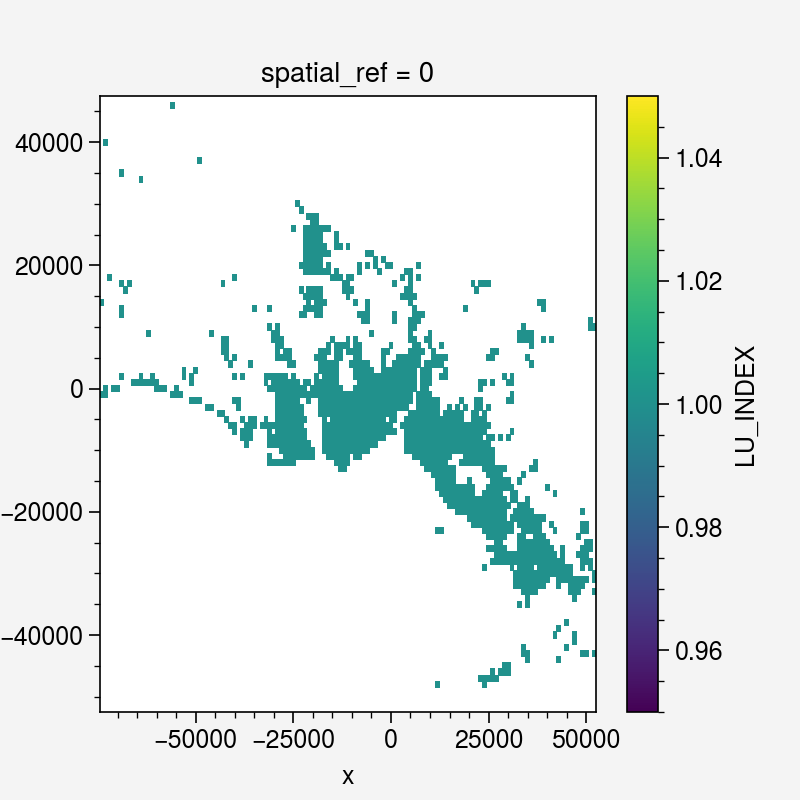

In [11]:
gg.plot()

In [12]:
gg = gg.rio.write_crs(proj_dt.rio.crs)
gdf = xr_vectorize(gg,
                   crs=gg.rio.crs,
                   mask=gg.values==1)

<AxesSubplot:>

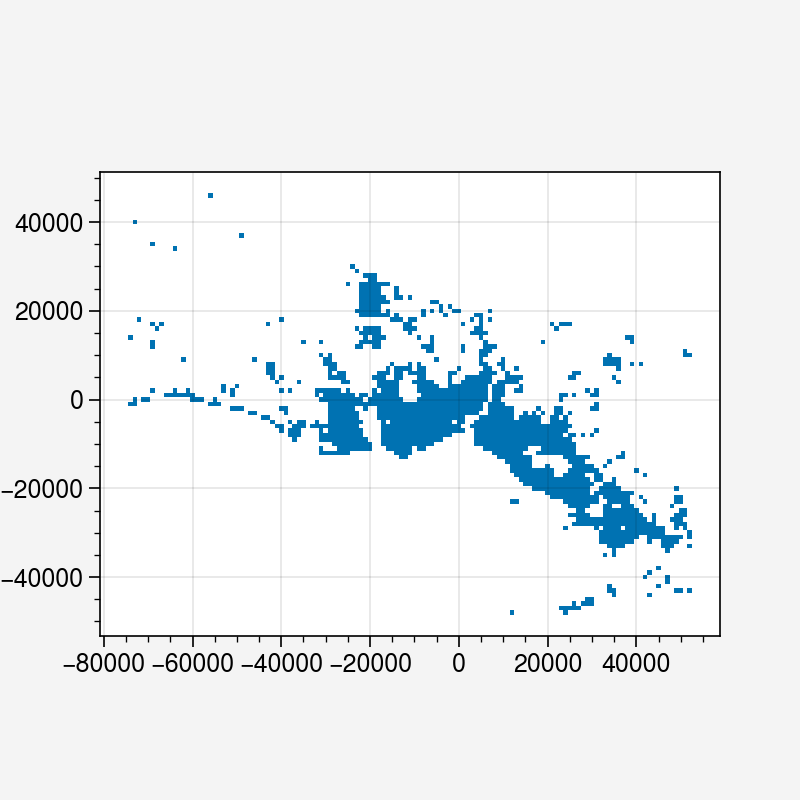

In [13]:
gdf.plot()

In [14]:
def clip_to_city(data, shapefile, crs_data, x_dims, y_dims):
    
    data= data.rio.set_spatial_dims(x_dim=x_dims, y_dim=y_dims)

    data = data.rio.write_crs(crs_data)
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [15]:
x_dims = 'west_east'
y_dims = 'south_north'

## 3. Clip IVT for urban borders

In [16]:
ivt_era5_urban_clip = clip_to_city(ivt_era5_urban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_era5_nourban_clip = clip_to_city(ivt_era5_nourban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_gfs_urban_clip = clip_to_city(ivt_gfs_urban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

ivt_gfs_nourban_clip = clip_to_city(ivt_gfs_nourban, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

In [17]:
prcp_era5_urban_clip = clip_to_city(prcp_era5_urban_clip, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

prcp_era5_nourban_clip = clip_to_city(prcp_era5_nourban_clip, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

prcp_gfs_urban_clip = clip_to_city(prcp_gfs_urban_clip, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

prcp_gfs_nourban_clip = clip_to_city(prcp_gfs_nourban_clip, gdf, 
                                 gg.rio.crs, 
                                 x_dims,
                                 y_dims)

## 4. Calculate Urban Nourban Differences

### 4.1 IVT Data

In [18]:
# era5 grid-based diff urban borders
ivt_era5_urban_minus_nourban = ivt_era5_urban_clip[variable_ivt] - ivt_era5_nourban_clip[variable_ivt] 

# gfs grid-based diff urban borders
ivt_gfs_urban_minus_nourban = ivt_gfs_urban_clip[variable_ivt] - ivt_gfs_nourban_clip[variable_ivt]

### 4.2 PRCP Data

In [19]:
# era5 grid-based diff urban borders
prcp_era5_urban_minus_nourban = prcp_era5_urban_clip[variable_prcp] - prcp_era5_nourban_clip[variable_prcp] 

# gfs grid-based diff urban borders
prcp_gfs_urban_minus_nourban = prcp_gfs_urban_clip[variable_prcp] - prcp_gfs_nourban_clip[variable_prcp]

## 5. Turn Xarray to Pandas DataFrame

In [20]:
def xr_to_pd(dt_era5_diff, dt_gfs_diff, required_cols):
    
    pd_era5_urban_minus_nourban = dt_era5_diff.to_dataframe().dropna().reset_index()[required_cols]
    pd_gfs_urban_minus_nourban = dt_gfs_diff.to_dataframe().dropna().reset_index()[required_cols]
    
    # equate time dims for vis. purposes
    pd_era5_urban_minus_nourban['time'] = pd_gfs_urban_minus_nourban['time']
    
    # make time dim easier to understand
    repeating = len(pd_era5_urban_minus_nourban) / 6
    time_numbers = np.repeat(np.array(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']),
                             repeating, axis=0).flatten()

    pd_era5_urban_minus_nourban['time'] = time_numbers
    pd_gfs_urban_minus_nourban['time'] = time_numbers
    
    return pd_era5_urban_minus_nourban, pd_gfs_urban_minus_nourban

### 5.1 IVT Data

In [21]:
required_cols = ['time', 'XLONG', 'XLAT', variable_ivt]
pd_ivt_era5_urban_minus_nourban, pd_ivt_gfs_urban_minus_nourban = xr_to_pd(ivt_era5_urban_minus_nourban,
                                                                        ivt_gfs_urban_minus_nourban,
                                                                        required_cols)

### 5.2 PRCP Data

In [22]:
required_cols = ['time', variable_prcp]
pd_prcp_era5_urban_minus_nourban, pd_prcp_gfs_urban_minus_nourban = xr_to_pd(prcp_era5_urban_minus_nourban,
                                                                        prcp_gfs_urban_minus_nourban,
                                                                        required_cols)

## 6. Visualization

### 6.1 Details to Plot

#### 6.1.1 IVT Data

In [23]:
pd_ivt_gfs_urban_minus_nourban['forcing'] = 'gfs'
pd_ivt_era5_urban_minus_nourban['forcing'] = 'era5'

In [24]:
pd_ivt_gfs_urban_minus_nourban = pd_ivt_gfs_urban_minus_nourban.rename(columns={variable_ivt:'value'})
pd_ivt_era5_urban_minus_nourban = pd_ivt_era5_urban_minus_nourban.rename(columns={variable_ivt:'value'})

In [25]:
viol_ivt_gfs = pd_ivt_gfs_urban_minus_nourban.drop(columns=['XLONG', 'XLAT'])
viol_ivt_era5 = pd_ivt_era5_urban_minus_nourban.drop(columns=['XLONG', 'XLAT'])

In [26]:
viol_ivt = pd.concat([viol_ivt_gfs, viol_ivt_era5], axis=0).reset_index(drop=True)

#### 6.1.2 PRCP Data

In [27]:
pd_prcp_gfs_urban_minus_nourban['forcing'] = 'gfs'
pd_prcp_era5_urban_minus_nourban['forcing'] = 'era5'

In [28]:
pd_prcp_gfs_urban_minus_nourban = pd_prcp_gfs_urban_minus_nourban.rename(columns={variable_prcp:'value'})
pd_prcp_era5_urban_minus_nourban = pd_prcp_era5_urban_minus_nourban.rename(columns={variable_prcp:'value'})

In [29]:
viol_prcp_gfs = pd_prcp_gfs_urban_minus_nourban
viol_prcp_era5 = pd_prcp_era5_urban_minus_nourban

In [30]:
viol_prcp = pd.concat([viol_prcp_gfs, viol_prcp_era5], axis=0).reset_index(drop=True)
viol_prcp = viol_prcp.groupby(['time', 'forcing']).mean().reset_index()

### 6.2 Plot

In [ ]:
fig, axes = plt.subplot_mosaic([['a'],[ 'b']],
                              constrained_layout=True)
for label, ax in axes.items():
    ax.set_title(label, loc='left', fontweight='bold', fontsize=15, y=0.83, x=0.02)

# violinplot
ax1=sns.violinplot(data=viol_ivt,
                   x='time',
                   y='value',
                   hue='forcing',
                   hue_order=['era5', 'gfs'],
                   palette=['red', 'blue'],
                   split=True,
                   showfliers = False,
                   color='red',
                   saturation=1,
                   ax=axes['a']
                )

# barplot
ax2=sns.barplot(data=viol_prcp,
                   x='time',
                   y='value',
                   hue='forcing',
                   hue_order=['era5', 'gfs'],
                   palette=['red', 'blue'],
                   saturation=0.8,
                edgecolor='black',
                alpha=1,
                ax=axes['b']
                )

# options
plt.setp(axes['a'].collections, alpha=1)
axes['a'].legend_.remove()
axes['a'].set_xlabel('')
axes['b'].set_xlabel('Time', size=12, weight='bold')
axes['b'].set_ylabel('mm', size=12, weight='bold')
axes['a'].set_ylabel('kg/ms', size=12, weight='bold')
axes['a'].set_ylim(-2000, 2000)
axes['b'].set_ylim(-6.2, 6.2)
axes['a'].tick_params(bottom=True, left=True, labelsize=10)
axes['b'].tick_params(bottom=True, left=True, labelsize=10)
axes['a'].minorticks_off()
axes['b'].minorticks_off()
sns.despine(bottom=False, ax=axes['b'])
sns.despine(bottom=False, ax=axes['a'])
fig.tight_layout(pad=1.0)
axes['b'].sharex(axes['a'])
plt.legend(loc='lower left')
axes['a'].axhline(y=0, color='black', linestyle='--', lw=0.2)
axes['b'].axhline(y=0, color='black', linestyle='--', lw=0.2)

#save figure
plt.savefig(r'pictures/Figure9.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)

## 7. Supporting Calculations

In [20]:
pd_ivt_era5_urban_minus_nourban['time'] = pd_ivt_era5_urban_minus_nourban['time'].astype('str')

In [23]:
#i = 0 # time indicator

for i in range(6):
    t = pd_ivt_era5_urban_minus_nourban['time'].unique()[i]
    d = pd_ivt_gfs_urban_minus_nourban['time'].unique()[i]

    print(fr"era5 median IVT diff. for {t}: ", pd_ivt_era5_urban_minus_nourban.query(fr'time=="{t}"')[variable].median())
    print(fr"gfs median IVT diff. for {d}: ", pd_ivt_gfs_urban_minus_nourban.query(fr'time=="{d}"')[variable].median())
    print('-------------')

era5 median IVT diff. for 2017-07-18 07:00:00:  166.1591796875
gfs median IVT diff. for 2017-07-18T03:00:00.000000000:  5.2904052734375
-------------
era5 median IVT diff. for 2017-07-18 08:00:00:  18.7177734375
gfs median IVT diff. for 2017-07-18T04:00:00.000000000:  -56.30389404296875
-------------
era5 median IVT diff. for 2017-07-18 09:00:00:  -254.257568359375
gfs median IVT diff. for 2017-07-18T05:00:00.000000000:  25.052734375
-------------
era5 median IVT diff. for 2017-07-18 10:00:00:  -249.0234375
gfs median IVT diff. for 2017-07-18T06:00:00.000000000:  120.479736328125
-------------
era5 median IVT diff. for 2017-07-18 11:00:00:  -44.13720703125
gfs median IVT diff. for 2017-07-18T07:00:00.000000000:  0.4587249755859375
-------------
era5 median IVT diff. for 2017-07-18 12:00:00:  -72.9521484375
gfs median IVT diff. for 2017-07-18T08:00:00.000000000:  -108.32595825195312
-------------
